In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc

from sklearn.naive_bayes import MultinomialNB

In [7]:
#files on disk
scores_file = 'full_dataset.csv'
vector_file_raw = 'X_raw.npy'
vector_file_clean = 'X_cleaned.npy'

#load files
df = pd.read_csv(scores_file, index_col=0)

X_raw = np.load(vector_file_raw)
X_clean = np.load(vector_file_clean)

y = df['PHQ8_Binary'].values

In [3]:
print(X_raw.shape)
print(X_clean.shape)

(8369, 189)
(7853, 189)


Pre-processing the data has taken out about 500 words. Now let's do some EDA on the full dataset.

### EDA

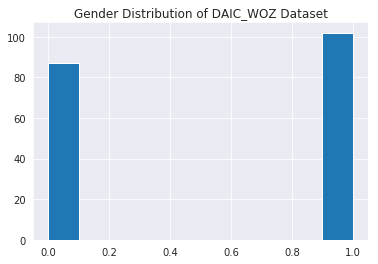

In [4]:
plt.hist(df['Gender'])
plt.title('Gender Distribution of DAIC_WOZ Dataset')
plt.show()

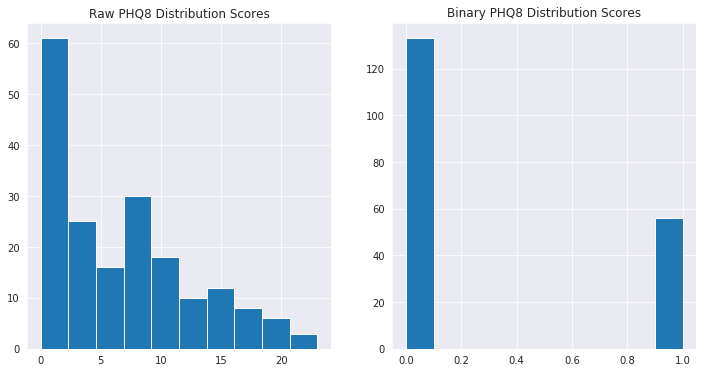

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(df['PHQ8_Score'])
ax[0].set_title('Raw PHQ8 Distribution Scores')

ax[1].hist(df['PHQ8_Binary'])
ax[1].set_title('Binary PHQ8 Distribution Scores')

plt.show()

In [6]:
print(np.sum(df['PHQ8_Binary']==0))
print(np.sum(df['PHQ8_Binary']==1))

133
56


Our gender distribution is slightly skewed, but we are more interested in PHQ8 scores. As we can see, the DAIC_WOZ dataset is heavily skewed towards those who score lower on the PHQ8 scale. This could be due to how the binary scores were calculated, although it does seem from the plot on the left of the raw scores that most participants score lower on the PHQ8 scale. This almost 3-1 ratio will need to be taken into account when splitting the data for training. If we are not careful, the splits can miss the "true" distribution of the data, and our models will be biased. In this case, it will be best to use the StratifiedKFold method in scikit-learn when doing cross-validation.

### Training, Classification

In [7]:
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X_raw, y)

nbayes = MultinomialNB()

In [8]:
print(X_raw.shape)
print(y.shape)

(8369, 189)
(189,)


In [11]:
#for reporting metrics
accuracy, precision, recall, fbeta = [], [], [], []

#for roc curve
fpr, tpr, threshold = [], [], []

#loop over n splits
for train_idx, test_idx in skf.split(X_raw, y):
    #get subsets of data
    X_train, X_test = X_raw[train_idx], X_raw[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    #fit and predict on training and test data
    preds = nbayes.fit(X_train, y_train).predict(X_test)
    
    #calculate scores and append to lists
    acc = accuracy_score(y_test, preds)
    accuracy.append(acc)
    
    pre = precisions_score(y_test, preds)
    precision.append(pre)
    
    rec = recall_score(y_test, preds)
    recall.append(rec)
    
    fb = fbeta_score(y_test, preds)
    fbeta.append(fb)
    
    #append false positive rate, true positive rate, and threshold values for roc curve
    fpr_nb, tpr_nb, thresh = roc_curve(y_test, preds)
    fpr.append(fpr_nb)
    tpr.append(tpr_nb)
    threshold.append(thresh)

ValueError: Found input variables with inconsistent numbers of samples: [8369, 189]

We have already decided to use either the Fbeta score or recall for our purposes. This decision was  made based on trying to reduce our Type 2 errors, where someone identifies as being depressed or scores high on the PHQ8 scale, yet our model misclassifies them. When weighing the other metrics, we think Type 1 errors are more permissable.

In [ ]:
#calculate means of scores for reporting
mean_accuracy = np.round(accuracy.mean(), 4)
mean_precision = np.round(precision.mean(), 4)
mean_recall = np.round(recall.mean(), 4)
mean_fbeta = np.round(fbeta.mean(), 4)

print('Mean accuracy score: ', mean_accuracy)
print('Mean precision score: ', mean_precision)
print('Mean recall score: ', mean_recall)
print('Mean fbeta score: ', mean_fbeta)

In [ ]:
plt.plot(accuracy, label='acc', color='r')

plt.plot(precision, label='prec', color='g')

plt.plot(recall, label='rec', color='b')

plt.plot(fbeta, label='fb', color='purple')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('How Metrics Vary Across Stratified Splits')
plt.show()

In [ ]:
print(fpr.shape())
print(tpr.shape())

In [ ]:
#average over fpr, tpr, threshold
fpr_mean = fpr.mean()
tpr_mean = tpr.mean()

#roc curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_mean, tpr_mean, 'r', label='NB')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# xx = np.arange(0, 1, .05)
# yy = np.arange(0, 1, .05)
# xx_, yy_ = np.meshgrid(xx, yy)

# X_star = nbayes.predict(np.c_[xx_.ravel(), yy_.ravel()])
# X_star = X_star.reshape(xx_.shape)

# cmap = plt.get_cmap('Pastel2')

# plt.figure(figsize=(8, 8))
# plt.pcolormesh(xx_, yy_, X_star, cmap=cmap)
# plt.scatter(y, y, alpha=0.5, c=y)
# plt.xlabel('')
# plt.ylabel('')
# plt.tight_layout()
# plt.show()